In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahsanmukhtar","key":"99020d3eb3f7a326d8294a9dc1d2eccd"}'}

In [ ]:
 ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                       title                                               size  lastUpdated          downloadCount  
--------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
terenceshin/covid19s-impact-on-airport-traffic            COVID-19's Impact on Airport Traffic               106KB  2020-10-19 12:40:17            898  
sootersaalu/amazon-top-50-bestselling-books-2009-2019     Amazon Top 50 Bestselling Books 2009 - 2019         15KB  2020-10-13 09:39:21            938  
thomaskonstantin/highly-rated-children-books-and-stories  Highly Rated Children Books And Stories            106KB  2020-10-24 12:09:59            227  
tunguz/euro-parliament-proceedings-1996-2011              Euro Parliament Proceedings 1996 - 2011              1GB  2020-10-26 17:48:29             13  
rishidamarla/judicial-expenditures-across-all-50-states   Judicial Expenditures ac

In [ ]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 47.4MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 99.1MB/s]
 81% 19.0M/23.4M [00:00<00:00, 20.7MB/s]
100% 23.4M/23.4M [00:00<00:00, 34.3MB/s]
 80% 21.0M/26.3M [00:01<00:00, 7.36MB/s]
100% 26.3M/26.3M [00:01<00:00, 15.6MB/s]


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-10-31 14:43:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-31 14:43:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-31 14:43:21--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip /content/glove.6B.zip

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!unzip train.csv.zip
!unzip test.csv.zip
!unzip test_labels.csv.zip
!unzip sample_submission.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  test_labels.csv.zip
  inflating: test_labels.csv         
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [ ]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10 

In [ ]:
print('Loading word vectors..')
word2vec = {}

with open('/content/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found ' + str(len(word2vec)) +' word vectors.')

Loading word vectors..
Found 400000 word vectors.


In [ ]:
import pandas as pd

print('loading in comments...')

train = pd.read_csv('train.csv')
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

loading in comments...


In [ ]:
print("max sequence length:", max(len(s) for s in sentences))
print("min sequence length:", min(len(s) for s in sentences))

s = sorted(len(s) for s in sentences)
print("medium sequence length: ", s[len(s) // 2])

max sequence length: 5000
min sequence length: 6
medium sequence length:  205


In [ ]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [ ]:
word2idx = tokenizer.word_index
print("Found "+ str(word2idx) + 'unique tokens.')

data = pad_sequences(sequences, maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor: ',data.shape)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Shape of data tensor:  (159571, 100)


In [ ]:
print('Filling pre-trained embeddings...')

num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2idx.items():
    if i< MAX_VOCAB_SIZE:
        
        embedding_vector = word2vec.get(word)
        
        if embedding_vector is not None:

            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [ ]:
embedding_layers = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights = [embedding_matrix],
    input_length = MAX_SEQUENCE_LENGTH,
    trainable = False
)

print('Build model...')

Build model...


In [ ]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH, ))

x = embedding_layers(input_)

x = Bidirectional(LSTM(15, return_sequences=True))(x)

x = GlobalMaxPool1D()(x)

output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.01),
              metrics=['accuracy'])

print('Training model...')

r = model.fit(
    data,
    targets,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10
998/998 [==============================] - 92s 92ms/step - loss: 0.0673 - accuracy: 0.9505 - val_loss: 0.0549 - val_accuracy: 0.9815
Epoch 2/10
998/998 [==============================] - 91s 91ms/step - loss: 0.0506 - accuracy: 0.9759 - val_loss: 0.0505 - val_accuracy: 0.9396
Epoch 3/10
998/998 [==============================] - 91s 91ms/step - loss: 0.0482 - accuracy: 0.9723 - val_loss: 0.0503 - val_accuracy: 0.9718
Epoch 4/10
998/998 [==============================] - 91s 91ms/step - loss: 0.0469 - accuracy: 0.9683 - val_loss: 0.0505 - val_accuracy: 0.9851
Epoch 5/10
998/998 [==============================] - 91s 91ms/step - loss: 0.0460 - accuracy: 0.9669 - val_loss: 0.0497 - val_accuracy: 0.9740
Epoch 6/10
998/998 [==============================] - 91s 91ms/step - loss: 0.0454 - accuracy: 0.9679 - val_loss: 0.0494 - val_accuracy: 0.9855
Epoch 7/10
998/998 [==============================] - 92s 92ms/step - loss: 0.0444 - accuracy: 0.9674 - val_loss: 0.05

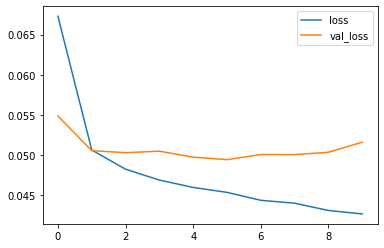

In [ ]:
 plt.plot(r.history['loss'], label='loss')
 plt.plot(r.history['val_loss'], label='val_loss')
 plt.legend()
 plt.show()

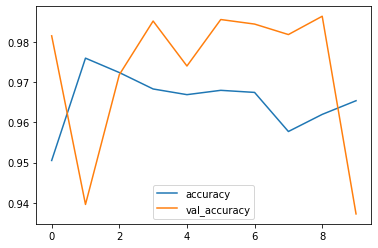

In [ ]:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:, j], p[:, j])
    aucs.append(auc)

print(np.mean(aucs))

0.9853329480525641
